In [1]:
library(openxlsx)
library(dplyr)
library(GSVA)
library("survival")
library(survminer)
library(pROC)
library(estimate)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




In [2]:
CELLTYPE_MARKERS_PATH = './publication/cellType_signatures_list.gmt'
SIGNATURES_PATH = './publication/Supplementary Table 3.xlsx'

In [23]:
calScore = function(matrix,gsets, method = 'ssgsea',ssgsea_norm=TRUE){
    score = GSVA::gsva(as.matrix(matrix), gset.idx.list = gsets, method=method,ssgsea.norm=ssgsea_norm)
    score = as.data.frame(t(score))
    return(score)
}

getSurvival = function(score, anno, time_name, status_name){
    anno[,'time'] = anno[,time_name]
    anno[,'status'] = anno[,status_name]
    res = c()
    for(g in colnames(score)){
        if(g !='group'){
            anno[,'g'] = as.numeric(score[,g]>median(score[,g],na.rm = T))
            fit <- survdiff(Surv(time, status) ~ g, data = anno)
            res = c(res, 1 - pchisq(fit$chisq, length(fit$n) -1))
        }
    }
    names(res) = colnames(score)[which(colnames(score)!='group')]
    return(res)
}

getROC = function(score,anno){
    res = c()
    for(g in colnames(score)){
    if(g!='group'){
        anno[,'g'] = score[,g]
        res = c(res, auc(roc(anno$group,anno$g,levels=c("NCR","CR"))))
    }    
    }
    names(res) = colnames(score)[which(colnames(score)!='group')]
    return(res)
}

fpkmToTpm <- function(fpkm)
{
    exp(log(fpkm) - log(sum(fpkm)) + log(1e6))
}


countToTpm <- function(count){
    geneLength = read.table('/share/pub/zhangyr/genome_annotation/genes/human/geneLength.txt',row.names = 1)
    inter_genes = intersect(rownames(count),rownames(geneLength))
    count = count[inter_genes, ]
    geneLength = geneLength[inter_genes, ]
    #TPM计算
    kb <- geneLength/ 1000
    rpk <- count / kb
    tpm <- t(t(rpk)/colSums(rpk) * 1000000)
    return(tpm)
}

In [4]:
gsets = testSctpa::getGMT(CELLTYPE_MARKERS_PATH)
sigs = read.xlsx(SIGNATURES_PATH)
progenitor = as.character(sigs[3,4:ncol(sigs)])
progenitor = progenitor[!is.na(progenitor)]
terminal = as.character(sigs[4,4:ncol(sigs)])
terminal = terminal[!is.na(terminal)]

gsets[['Progenitor Exhausted CD8']] = progenitor
gsets[['Terminally Exhausted CD8']] = terminal
gsets[['TLS']] = c('CCL19', 'CCL21', 'CXCL13', 'CCR7', 'SELL', 'LAMP3', 'CXCR4', 'CD86', 'BCL6')
gsets[['signature_pdcd1_spry1_ctla4_cd8a']] = c('CD8A','CTLA4','PDCD1','SPRY1')
gsets[['signature_pdcd1_spry1_cd8a']] = c('CD8A','PDCD1','SPRY1')
gsets[['signature_pdcd1_ctla4_cd8a']] = c('CD8A','PDCD1','CTLA4')
gsets[['signature_pdcd1_cxcl13_cd8a']] = c('CD8A','PDCD1','CXCL13')
gsets[['tumorReactTIL']] = c('ENTPD1','CXCL13','HLA-DRA')

## SHC data set
* 40 samples
* Figure 3D; Figure3E; Figure3F

In [36]:
load('./bulk_data/SHC_40_TPM.RData')

In [37]:
shc_score = calScore(as.matrix(shc_data),gsets[c(11,13,14)], 'ssgsea')

Warning message in .filterFeatures(expr, method):
“218 genes with constant expression values throuhgout the samples.”


Estimating ssGSEA scores for 3 gene sets.
  |======================================================================| 100%



In [38]:
shc_score$PDL1 = shc_anno$PDL1expression_IHC

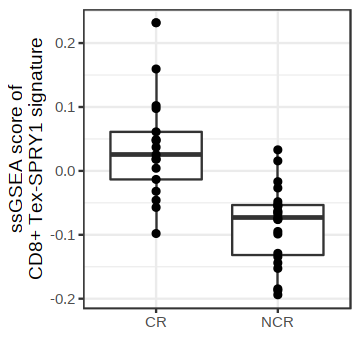

In [41]:
plot_data = shc_score
plot_data$group = shc_anno[rownames(plot_data),'group']
options(repr.plot.width=3, repr.plot.height=3)
ggplot(plot_data,aes(x=group,y=signature_pdcd1_spry1_cd8a))+geom_boxplot()+geom_point()+theme_bw()+
ylab('ssGSEA score of\nCD8+ Tex-SPRY1 signature')+xlab('')

In [42]:
getROC(shc_score, shc_anno)

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



signature_pdcd1_spry1_cd8a signature_pdcd1_cxcl13_cd8a 
                  0.9028133                   0.8260870 
              tumorReactTIL                        PDL1 
                  0.7416880                   0.5946292

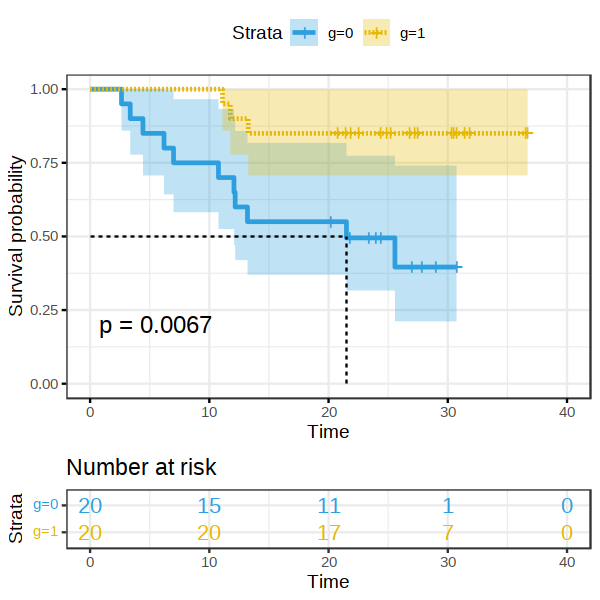

In [45]:
shc_anno[,'g'] = as.numeric(shc_score[,'signature_pdcd1_spry1_cd8a']>median(shc_score[,'signature_pdcd1_spry1_cd8a'],na.rm = T))
fit <- survfit(Surv(DFS_time, DFS_status) ~ g, data = shc_anno)
options(repr.plot.width=5, repr.plot.height=5)
ggsurvplot(fit,
       pval = TRUE, conf.int = TRUE,
       risk.table = TRUE, # Add risk table
       risk.table.col = "strata", # Change risk table color by groups
       linetype = "strata", # Change line type by groups
       surv.median.line = "hv", # Specify median survival
       ggtheme = theme_bw(), # Change ggplot2 theme
       palette = c("#2E9FDF","#E7B800")
       )

Setting direction: controls < cases

Setting direction: controls < cases



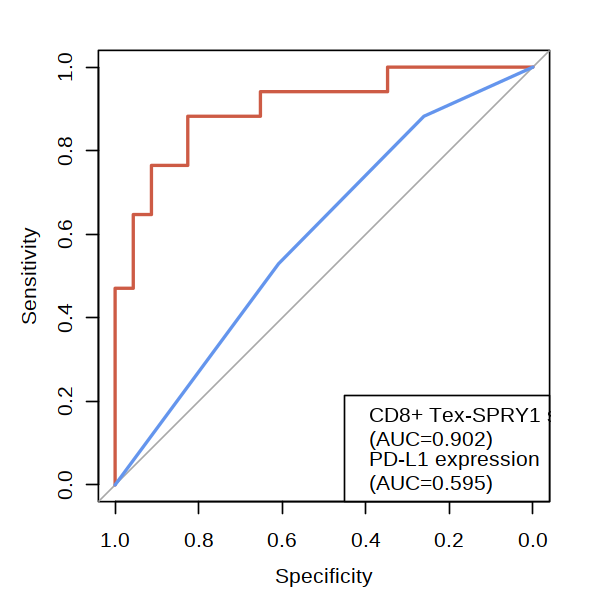

In [57]:
shc_score$group = shc_anno$group
roc_tex = roc(shc_score$group,shc_score$signature_pdcd1_spry1_cd8a,levels=c("NCR","CR"))
roc_pdl1 = roc(shc_score$group,shc_score$PDL1,levels=c("NCR","CR"))

plot(roc_tex,col = 'coral3')
plot(roc_pdl1,add = T,col='cornflowerblue')
legend('bottomright',legend = c('CD8+ Tex-SPRY1 signature\n(AUC=0.902)\n', 'PD-L1 expression\n(AUC=0.595)\n'))

## TCGA data set
* 81 samples
* Figure S5I; FigureS6I

In [9]:
load('./bulk_data/TCGA_ESCC.RData')

In [10]:
TCGA_score = calScore(as.matrix(TCGA_data),gsets[c(1,2,3)],'ssgsea')

Warning message in .filterFeatures(expr, method):
“2446 genes with constant expression values throuhgout the samples.”


Estimating ssGSEA scores for 3 gene sets.
  |======================================================================| 100%



`geom_smooth()` using formula 'y ~ x'




	Pearson's product-moment correlation

data:  TCGA_score[, "CD8+Tex_SPRY1"] and TCGA_score[, "Macro_MMP9"]
t = 4.0692, df = 79, p-value = 0.000111
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2177117 0.5817455
sample estimates:
      cor 
0.4162727 



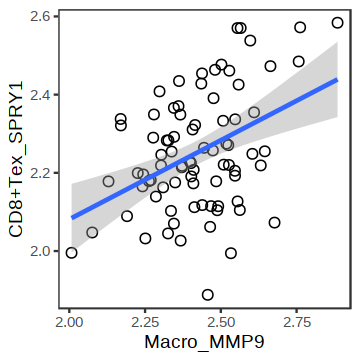

In [11]:
ggplot(TCGA_score,aes(x=`Macro_MMP9`,y=`CD8+Tex_SPRY1`))+
geom_point(shape=1,size=2.3)+
theme_bw()+theme(
    panel.grid = element_blank(),
    panel.background = element_blank()
)+ geom_smooth(
               method = "lm")
print(cor.test(TCGA_score[,'CD8+Tex_SPRY1'],TCGA_score[,'Macro_MMP9']))

`geom_smooth()` using formula 'y ~ x'




	Pearson's product-moment correlation

data:  TCGA_score[, "CD8+Tex_SPRY1"] and TCGA_score[, "Bfoc_NEIL1"]
t = 7.1334, df = 79, p-value = 4.148e-10
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4720882 0.7427557
sample estimates:
      cor 
0.6259178 



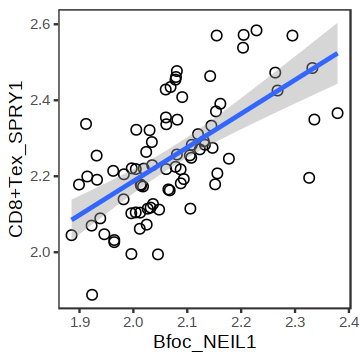

In [12]:
ggplot(TCGA_score,aes(x=`Bfoc_NEIL1`,y=`CD8+Tex_SPRY1`))+
geom_point(shape=1,size=2.3)+
theme_bw()+theme(
    panel.grid = element_blank(),
    panel.background = element_blank()
)+ geom_smooth(
               method = "lm")
print(cor.test(TCGA_score[,'CD8+Tex_SPRY1'],TCGA_score[,'Bfoc_NEIL1']))

`geom_smooth()` using formula 'y ~ x'




	Pearson's product-moment correlation

data:  TCGA_score[, "Bfoc_NEIL1"] and TCGA_score[, "Macro_MMP9"]
t = 3.493, df = 79, p-value = 0.0007856
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1602032 0.5409090
sample estimates:
      cor 
0.3657583 



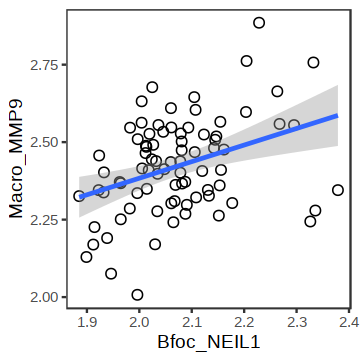

In [13]:
ggplot(TCGA_score,aes(x=`Bfoc_NEIL1`,y=`Macro_MMP9`))+
geom_point(shape=1,size=2.3)+
theme_bw()+theme(
    panel.grid = element_blank(),
    panel.background = element_blank()
)+ geom_smooth(
               method = "lm")
print(cor.test(TCGA_score[,'Bfoc_NEIL1'],TCGA_score[,'Macro_MMP9']))

## GEO: GSE53625
* 179 samples
* Figure S5I; FigureS6I

In [14]:
load('./bulk_data/GSE53625_ESCC.RData')

In [15]:
GEO_score = calScore(as.matrix(GEO_data),gsets[c(1,2,3)],'ssgsea')

Estimating ssGSEA scores for 3 gene sets.
  |======================================================================| 100%



`geom_smooth()` using formula 'y ~ x'




	Pearson's product-moment correlation

data:  GEO_score[, "CD8+Tex_SPRY1"] and GEO_score[, "Macro_MMP9"]
t = 12.063, df = 177, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5824094 0.7449794
sample estimates:
      cor 
0.6717026 



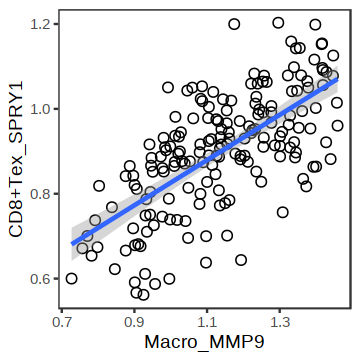

In [16]:
ggplot(GEO_score,aes(x=`Macro_MMP9`,y=`CD8+Tex_SPRY1`))+
geom_point(shape=1,size=2.3)+
theme_bw()+theme(
    panel.grid = element_blank(),
    panel.background = element_blank()
)+ geom_smooth(method = "lm")
print(cor.test(GEO_score[,'CD8+Tex_SPRY1'],GEO_score[,'Macro_MMP9']))

`geom_smooth()` using formula 'y ~ x'




	Pearson's product-moment correlation

data:  GEO_score[, "CD8+Tex_SPRY1"] and GEO_score[, "Bfoc_NEIL1"]
t = 14.369, df = 177, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6578937 0.7948864
sample estimates:
      cor 
0.7337618 



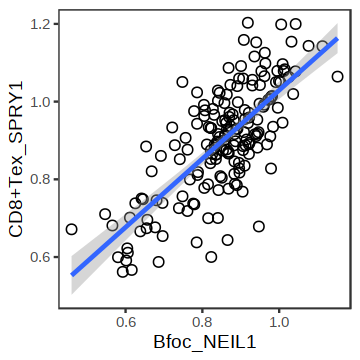

In [17]:
ggplot(GEO_score,aes(x=`Bfoc_NEIL1`,y=`CD8+Tex_SPRY1`))+
geom_point(shape=1,size=2.3)+
theme_bw()+theme(
    panel.grid = element_blank(),
    panel.background = element_blank()
)+ geom_smooth(method = "lm")
print(cor.test(GEO_score[,'CD8+Tex_SPRY1'],GEO_score[,'Bfoc_NEIL1']))

`geom_smooth()` using formula 'y ~ x'




	Pearson's product-moment correlation

data:  GEO_score[, "Bfoc_NEIL1"] and GEO_score[, "Macro_MMP9"]
t = 9.9415, df = 177, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4954126 0.6851113
sample estimates:
      cor 
0.5985894 



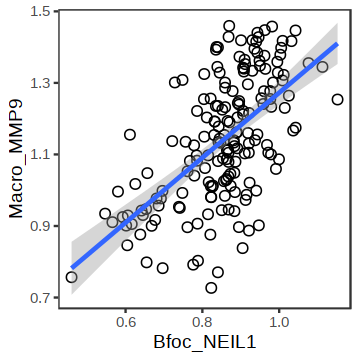

In [18]:
ggplot(GEO_score,aes(x=`Bfoc_NEIL1`,y=`Macro_MMP9`))+
geom_point(shape=1,size=2.3)+
theme_bw()+theme(
    panel.grid = element_blank(),
    panel.background = element_blank()
)+ geom_smooth(method = "lm")
print(cor.test(GEO_score[,'Bfoc_NEIL1'],GEO_score[,'Macro_MMP9']))